# UNET background editing

This is a small example to show how you can use Unet segmentation network to edit the background of a photo (which conatins atleast one people)
NB : I havent tested on input images with multiple instances. Here are some images to show what we are tring to achieve.


![title](demo_images/demo.png)

import numpy as np
import torch
import cv2
from model import Unet
from torchvision import transforms
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt

In [3]:
# Select your device, Now I m running on CPU-only machine
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Define the model config params
num_classes = 2 # "person" + "background" are the only classes

# Load the model and its weights
logs_path = '/home/robin/Thesis/Semantic-Segmentation-with-Unet/train_exp3-epoch65.pth'
model = Unet(3,num_classes)
model.to(device)
check_point =   torch.load(logs_path,map_location=torch.device('cpu'))
state_dict = check_point["model_state_dict"]


In [5]:
# Since the provided model was trained on multiple GPU, which stores the model in module 
# So for loading the weights, create a new ordered dict without the module prefix
# and load it back.
# More details : https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [7]:
model.eval()

Unet(
  (conv_encode1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_encode2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (downsample2): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [66]:
# Preapre tht input image
from PIL import Image
image = Image.open("./demo_images/messi.jpg")
image.size[::-1] # H,W as in opencv

(1062, 1600)

In [67]:
# preprocessing : resizing ---> (512*512) and normalization(pixel values are normalized bewtween 0 & 1)
image_resize = transforms.Resize((512,512))(image)
pil_to_tensor = transforms .ToTensor()(image_resize).unsqueeze_(0) #(N,C,W,H)


In [68]:
# make the prediction
pred = model(pil_to_tensor)
_,predicted = torch.max(pred,1)
# convert the output tensor into boolean numpy mask array
mask_numpy = predicted.numpy().astype(np.bool).transpose((1,2,0))

In [69]:
# Since we want to apply the segmentation result on the input image
# lets resize the seg map to input image shape
resized_mask = resize(mask_numpy, (image.size[::-1]))

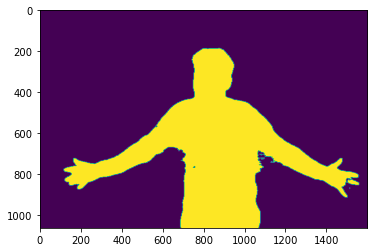

In [70]:
plt.imshow(resized_mask[:,:,0])

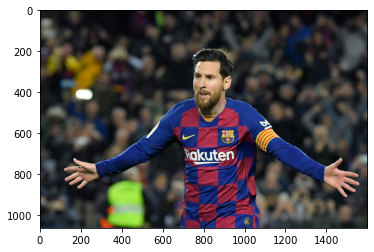

In [71]:
# Lets apply this mask on out input image
open_cv_image = np.array(image) 
# Convert RGB to BGR 
#open_cv_image = open_cv_image[:, :, ::-1].copy() 
plt.imshow(open_cv_image)

In [72]:
# Since we are making the background to grayscale, which inturn keep the focussed character colorful
# we need a grayscale image of the colrful input image for reference
open_cv_gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)


In [73]:
# Now apply the mask along all the hannel of input image
open_cv_image[:,:,0]  = np.where(resized_mask[:,:,0] ==0,open_cv_gray_image[:,:],open_cv_image[:,:,0])
open_cv_image[:,:,1]  = np.where(resized_mask[:,:,0] ==0,open_cv_gray_image[:,:],open_cv_image[:,:,1])
open_cv_image[:,:,2]  = np.where(resized_mask[:,:,0] ==0,open_cv_gray_image[:,:],open_cv_image[:,:,2])

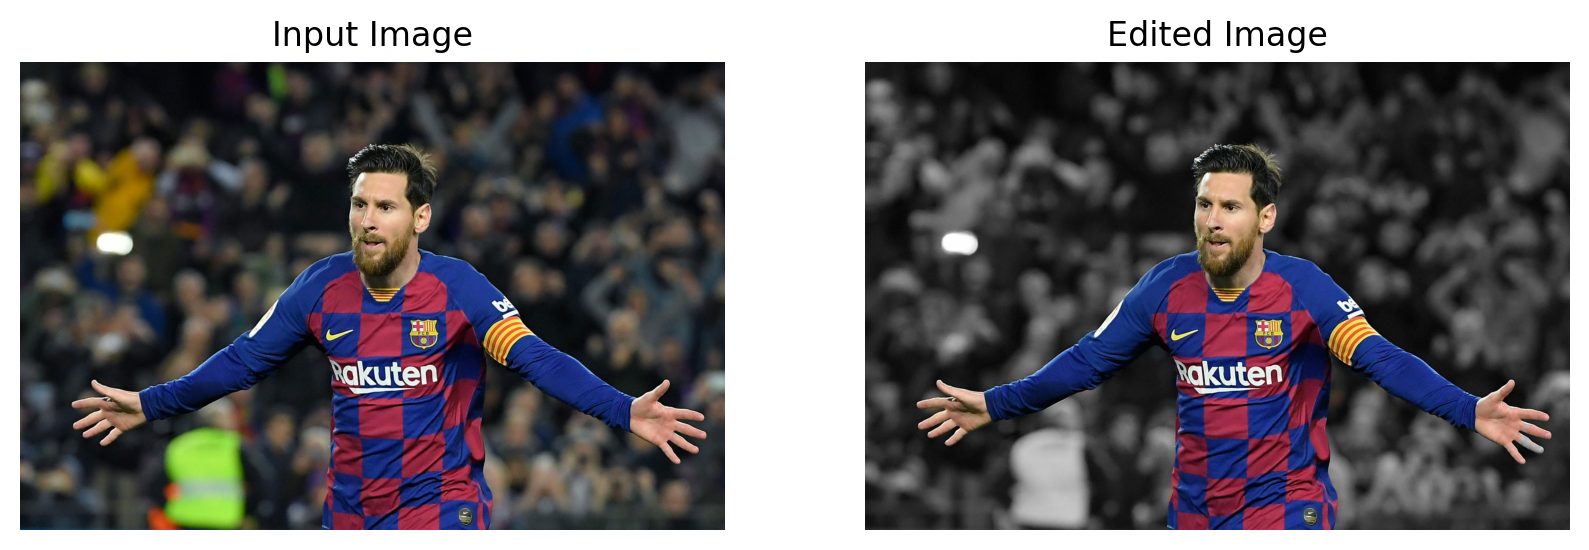

In [74]:
# lets visualize the output
fig = plt.figure(num =None,figsize =(10,10),dpi =200)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Input Image")
plt.axis('off')
plt.imshow(image)
ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title("Edited Image")
plt.axis('off')
plt.imshow(open_cv_image)

In [65]:
cv2.imwrite("edited messi.jpg",cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB))

True